In [1]:
!pip install -q line_profiler

In [2]:
import numpy as np
from typing import Union, Tuple
from line_profiler import LineProfiler
profile = LineProfiler()

In [3]:
@profile
def generate_data(n_samples: int, *, nx: Union[int, float] = 5, hbar: int = 1, m: Union[int, float] = 1, omega: Union[int, float] = 1) -> Tuple[np.ndarray, np.ndarray]:
  """

  Args:
    nx:
    hbar:
    m:
    omega:

  Returns:

  """
  def energy_levels(n1: int, n2: int) -> np.ndarray:
    return (n1 + n2 + 1) * hbar * omega

  # Define first 5 levels (n_x, n_y)
  levels = [(0, 0), (1, 0), (0, 1), (2, 0), (1, 1)]

  # Generate true wave functions and energy levels
  true_energy_levels = np.zeros(len(levels))

  # Generate meshgrid
  x = np.linspace(-nx, nx, n_samples)
  y = np.linspace(-nx, nx, n_samples)

  # X, Y = np.meshgrid(x, y)
  X, Y = np.ogrid[-nx:nx:len(x)*1j, -nx:nx:len(y)*1j]


  for i, (nx, ny) in enumerate(levels):
      true_energy_levels[i] = energy_levels(nx, ny)

  energy_indices = np.arange(len(levels)).reshape(-1, 1)

  return energy_indices, true_energy_levels, levels


generate_data(n_samples=100000)
profile.print_stats()

Timer unit: 1e-09 s

Total time: 0.00841998 s
File: <ipython-input-3-b22da0751124>
Function: generate_data at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           @profile
     2                                           def generate_data(n_samples: int, *, nx: Union[int, float] = 5, hbar: int = 1, m: Union[int, float] = 1, omega: Union[int, float] = 1) -> Tuple[np.ndarray, np.ndarray]:
     3                                             """
     4                                           
     5                                             Args:
     6                                               nx:
     7                                               hbar:
     8                                               m:
     9                                               omega:
    10                                           
    11                                             Returns:
    12                                 

# Learning 2D Simple Harmonic Oscillator

In [4]:
"""
Imports the pandas library, which provides data structures and data analysis tools for working with structured (tabular, multidimensional, potentially heterogeneous) and time series data.
"""
import pandas as pd
import tensorflow as tf
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split

import time
import pstats
import cProfile
from functools import wraps
from typing import Callable
from typing import NamedTuple

## Set seed for psuedo-random generators

In [5]:
tf.keras.utils.set_random_seed(seed=18)
np.random.seed(seed=18)

reports = []

In [6]:
class ModelReport(NamedTuple):
  model_type: str
  model_version: str
  fit_duration: float
  mean_squared_error: float

## Use deep learning to learn energy levels

In [7]:
def timer(func: Callable) -> Callable:
  @wraps(func)
  def wrapper(self, *args, **kwargs):
    start_time = time.time()
    result = func(self, *args, **kwargs)
    end_time = time.time()

    duration = end_time - start_time

    # Store duration in the class instance
    if not hasattr(self, '_method_durations'):
        self._method_durations = {}

    method_name = func.__name__
    self._method_durations[method_name] = duration

    print(f"\n\nMethod {func.__name__} took {duration:.4f} seconds to run.\n\n")
    return result
  return wrapper


In [8]:
class Experiment:
  """This class is used to run experiments.

  It takes in the model
  """
  def __init__(self, **kwargs):
    self.model = kwargs.get('model')
    self.optimizer = kwargs.get('optimizer')
    self.loss = kwargs.get('loss')

    self.model_version = kwargs.get('model_version')
    self.model_type = 'Multi_Layer_Perceptron'


  def set_model(self, model):
    self.model = model

  def set_hyperparameters(self, **kwargs):
    self.__dict__.update(kwargs)

  @timer
  def fit(self, X, y, epochs=200, batch_size=32, validation_split=0.2):
    self.model.compile(optimizer=self.optimizer, loss=self.loss)
    self.history_energy = self.model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=validation_split)

  def predict(self, X):
    predicted_energy_levels = self.model.predict(X).flatten()
    return predicted_energy_levels


  def plot_results(self, true_energy_levels, predicted_energy_levels, levels):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    # Plot the energy levels

    ax1.plot(np.arange(len(levels)), true_energy_levels, 'rx', label='True Energy Levels')
    ax1.plot(np.arange(len(levels)), predicted_energy_levels, 'bo', label='Predicted Energy Levels')
    ax1.set_xlabel('Energy Level Index')
    ax1.set_ylabel('Energy')
    ax1.set_title('True and Predicted Energy Levels')
    ax1.legend()


    # Plot log loss function vs epochs for energy levels
    ax2.plot(np.log(self.history_energy.history['loss']), label='Training Loss (Energy)')
    ax2.plot(np.log(self.history_energy.history['val_loss']), label='Validation Loss (Energy)')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Log(Loss)')
    ax2.set_title('Log(Loss) vs Epochs for Energy Levels')
    ax2.legend()

    plt.tight_layout()
    plt.show()


  def report(self, ):
    return ModelReport(
        model_type=self.model_type,
        model_version=self.model_version,
        fit_duration=self._method_durations['fit'],
        mean_squared_error=self.mse_energy_levels
    )


  def accuracy_metric(self, true_energy_levels, predicted_energy_levels):
    self.mse_energy_levels = np.mean((predicted_energy_levels - true_energy_levels)**2)
    print(f'Mean Squared Error (Energy Levels): {self.mse_energy_levels}')


  @staticmethod
  def generate_data(n_samples: int, *, nx: Union[int, float] = 5, hbar: int = 1, m: Union[int, float] = 1, omega: Union[int, float] = 1) -> Tuple[np.ndarray, np.ndarray]:
    """

    Args:
      nx:
      hbar:
      m:
      omega:

    Returns:

    """
    def energy_levels(n1: int, n2: int) -> np.ndarray:
      return (n1 + n2 + 1) * hbar * omega

    # Define first 5 levels (n_x, n_y)
    levels = [(0, 0), (1, 0), (0, 1), (2, 0), (1, 1)]

    # Generate true wave functions and energy levels
    true_energy_levels = np.zeros(len(levels))

    # Generate meshgrid
    x = np.linspace(-nx, nx, n_samples)
    y = np.linspace(-nx, nx, n_samples)

    # X, Y = np.meshgrid(x, y)
    X, Y = np.ogrid[-nx:nx:len(x)*1j, -nx:nx:len(y)*1j]


    for i, (nx, ny) in enumerate(levels):
        true_energy_levels[i] = energy_levels(nx, ny)

    energy_indices = np.arange(len(levels)).reshape(-1, 1)

    return energy_indices, true_energy_levels, levels


### Construct the network

In [9]:
# Build the neural network for energy levels
model_energy = Sequential([
    Input(shape=(1,)),
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dense(1, activation='linear')
])

### Experiment 1 - Sample Size of 1000

In [10]:
exp_1 = Experiment(model=model_energy, optimizer=Adam(learning_rate=0.001), loss='mse', model_version='v1')
energy_indices, true_energy_levels, levels = exp_1.generate_data(n_samples=1000)
exp_1.fit(energy_indices, true_energy_levels, epochs=200, batch_size=32, validation_split=0.2)
predicted_energy_levels = exp_1.predict(energy_indices)

Epoch 1/200
1/1 [==============================] - 6s 6s/step - loss: 5.5174 - val_loss: 8.1030
Epoch 2/200
1/1 [==============================] - 0s 63ms/step - loss: 4.1787 - val_loss: 5.5260
Epoch 3/200
1/1 [==============================] - 0s 46ms/step - loss: 3.3146 - val_loss: 3.4470
Epoch 4/200
1/1 [==============================] - 0s 42ms/step - loss: 2.5594 - val_loss: 1.7849
Epoch 5/200
1/1 [==============================] - 0s 43ms/step - loss: 1.8799 - val_loss: 0.5210
Epoch 6/200
1/1 [==============================] - 0s 40ms/step - loss: 1.2322 - val_loss: 5.3705e-04
Epoch 7/200
1/1 [==============================] - 0s 53ms/step - loss: 0.6830 - val_loss: 0.8315
Epoch 8/200
1/1 [==============================] - 0s 84ms/step - loss: 0.3671 - val_loss: 3.5579
Epoch 9/200
1/1 [==============================] - 0s 43ms/step - loss: 0.4467 - val_loss: 6.7982
Epoch 10/200
1/1 [==============================] - 0s 61ms/step - loss: 0.7928 - val_loss: 8.0965
Epoch 11/200
1/1 

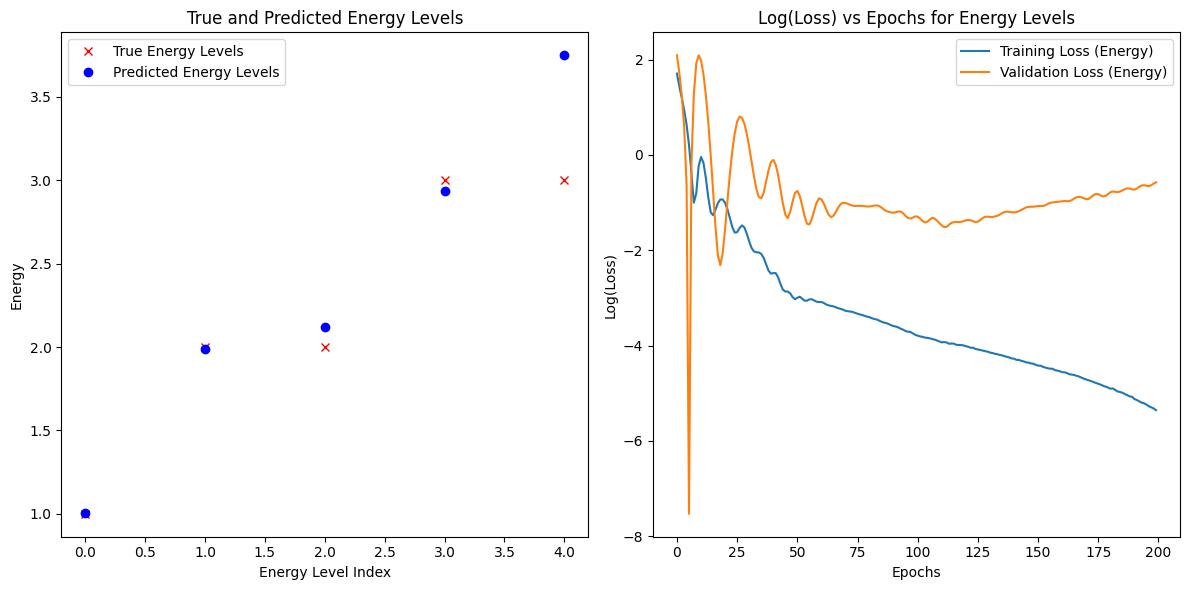

In [11]:
exp_1.plot_results(true_energy_levels, predicted_energy_levels, levels)

In [12]:
exp_1.accuracy_metric(true_energy_levels, predicted_energy_levels)
reports.append(exp_1.report())

Mean Squared Error (Energy Levels): 0.11625499790046945


### Experiment 1a - Sample Size of 1000 with slightly different activations

In [13]:
model_energy_1a = Sequential([
    Input(shape=(1,)),
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dense(256, activation='tanh'),
    Dense(1, activation='linear')
])

exp_1a = Experiment(model=model_energy_1a, optimizer=Adam(learning_rate=0.001), loss='mse', model_version='v1a')
energy_indices, true_energy_levels, levels = exp_1a.generate_data(n_samples=1000)
exp_1a.fit(energy_indices, true_energy_levels, epochs=200, batch_size=32, validation_split=0.2)
predicted_energy_levels = exp_1a.predict(energy_indices)

Epoch 1/200
1/1 [==============================] - 1s 1s/step - loss: 4.4494 - val_loss: 4.7261
Epoch 2/200
1/1 [==============================] - 0s 30ms/step - loss: 3.0272 - val_loss: 1.8853
Epoch 3/200
1/1 [==============================] - 0s 29ms/step - loss: 1.8941 - val_loss: 0.2158
Epoch 4/200
1/1 [==============================] - 0s 27ms/step - loss: 0.9694 - val_loss: 0.3863
Epoch 5/200
1/1 [==============================] - 0s 28ms/step - loss: 0.3925 - val_loss: 3.2503
Epoch 6/200
1/1 [==============================] - 0s 29ms/step - loss: 0.4611 - val_loss: 6.5767
Epoch 7/200
1/1 [==============================] - 0s 39ms/step - loss: 0.9189 - val_loss: 7.0777
Epoch 8/200
1/1 [==============================] - 0s 37ms/step - loss: 0.9970 - val_loss: 5.5117
Epoch 9/200
1/1 [==============================] - 0s 37ms/step - loss: 0.7381 - val_loss: 3.4152
Epoch 10/200
1/1 [==============================] - 0s 36ms/step - loss: 0.4395 - val_loss: 1.7512
Epoch 11/200
1/1 [===

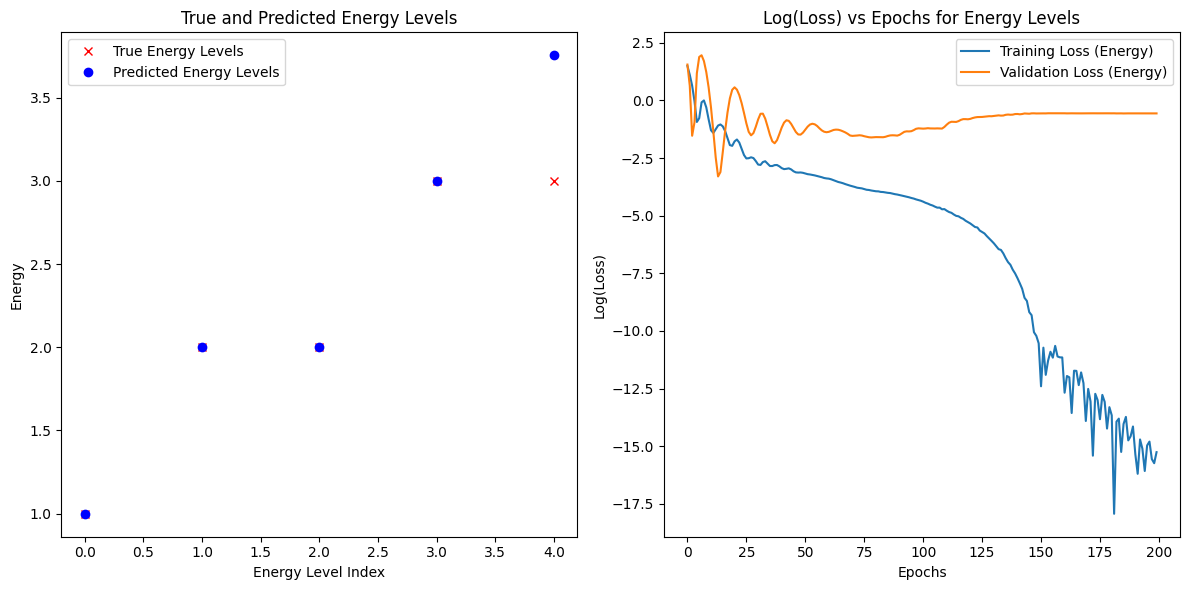

In [14]:
exp_1a.plot_results(true_energy_levels, predicted_energy_levels, levels)

In [15]:
exp_1a.accuracy_metric(true_energy_levels, predicted_energy_levels)
reports.append(exp_1a.report())

Mean Squared Error (Energy Levels): 0.11372746078989807


### Expriment 1b

In [16]:
model_energy_1b = Sequential([
    Input(shape=(1,)),
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dense(512, activation='tanh'),
    Dense(512, activation='tanh'),
    Dense(1, activation='linear')
])

exp_1b = Experiment(model=model_energy_1b, optimizer=Adam(learning_rate=0.001), loss='mse', model_version='v1b')
energy_indices, true_energy_levels, levels = exp_1b.generate_data(n_samples=1000)
exp_1b.fit(energy_indices, true_energy_levels, epochs=200, batch_size=32, validation_split=0.2)

Epoch 1/200
1/1 [==============================] - 3s 3s/step - loss: 4.6230 - val_loss: 3.0861
Epoch 2/200
1/1 [==============================] - 0s 33ms/step - loss: 2.3861 - val_loss: 0.0735
Epoch 3/200
1/1 [==============================] - 0s 32ms/step - loss: 0.5074 - val_loss: 11.8493
Epoch 4/200
1/1 [==============================] - 0s 31ms/step - loss: 1.7335 - val_loss: 6.7132
Epoch 5/200
1/1 [==============================] - 0s 30ms/step - loss: 0.8675 - val_loss: 1.1779
Epoch 6/200
1/1 [==============================] - 0s 30ms/step - loss: 0.2606 - val_loss: 9.5019e-05
Epoch 7/200
1/1 [==============================] - 0s 31ms/step - loss: 0.5074 - val_loss: 0.1855
Epoch 8/200
1/1 [==============================] - 0s 30ms/step - loss: 0.7382 - val_loss: 0.1520
Epoch 9/200
1/1 [==============================] - 0s 29ms/step - loss: 0.6585 - val_loss: 1.6221e-06
Epoch 10/200
1/1 [==============================] - 0s 29ms/step - loss: 0.3805 - val_loss: 0.4274
Epoch 11/200

1/1 [==============================] - 0s 75ms/step


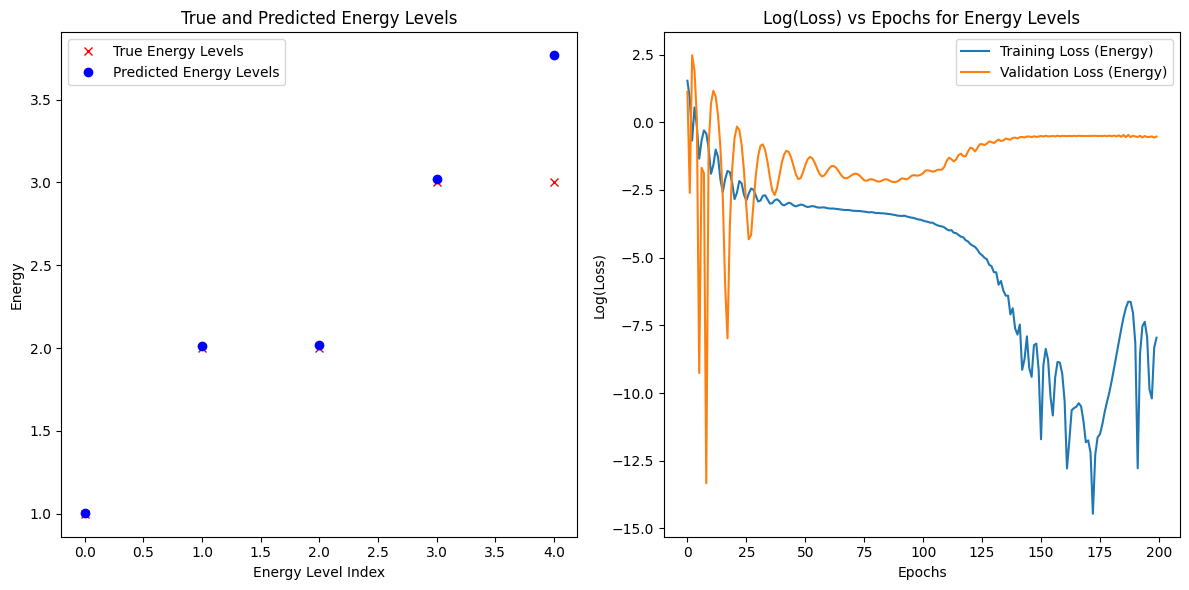

In [17]:
predicted_energy_levels = exp_1b.predict(energy_indices)
exp_1b.plot_results(true_energy_levels, predicted_energy_levels, levels)

In [18]:
exp_1b.accuracy_metric(true_energy_levels, predicted_energy_levels)
reports.append(exp_1b.report())

Mean Squared Error (Energy Levels): 0.11795589605046644


### Experiment 2 - Sample Size of 10000

In [19]:
exp_2 = Experiment(model=model_energy, optimizer=Adam(learning_rate=0.001), loss='mse', model_version='v2')
energy_indices, true_energy_levels, levels = exp_2.generate_data(n_samples=10000)
exp_2.fit(energy_indices, true_energy_levels, epochs=200, batch_size=250, validation_split=0.2)

Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 0.0046 - val_loss: 0.0176
Epoch 2/200
1/1 [==============================] - 0s 54ms/step - loss: 0.1623 - val_loss: 0.3055
Epoch 3/200
1/1 [==============================] - 0s 55ms/step - loss: 0.0612 - val_loss: 0.9521
Epoch 4/200
1/1 [==============================] - 0s 40ms/step - loss: 0.0966 - val_loss: 0.8346
Epoch 5/200
1/1 [==============================] - 0s 54ms/step - loss: 0.0235 - val_loss: 0.5221
Epoch 6/200
1/1 [==============================] - 0s 44ms/step - loss: 0.0078 - val_loss: 0.3537
Epoch 7/200
1/1 [==============================] - 0s 41ms/step - loss: 0.0297 - val_loss: 0.3678
Epoch 8/200
1/1 [==============================] - 0s 53ms/step - loss: 0.0419 - val_loss: 0.5446
Epoch 9/200
1/1 [==============================] - 0s 56ms/step - loss: 0.0376 - val_loss: 0.8415
Epoch 10/200
1/1 [==============================] - 0s 53ms/step - loss: 0.0360 - val_loss: 1.0859
Epoch 11/200
1/1 [===

1/1 [==============================] - 0s 79ms/step


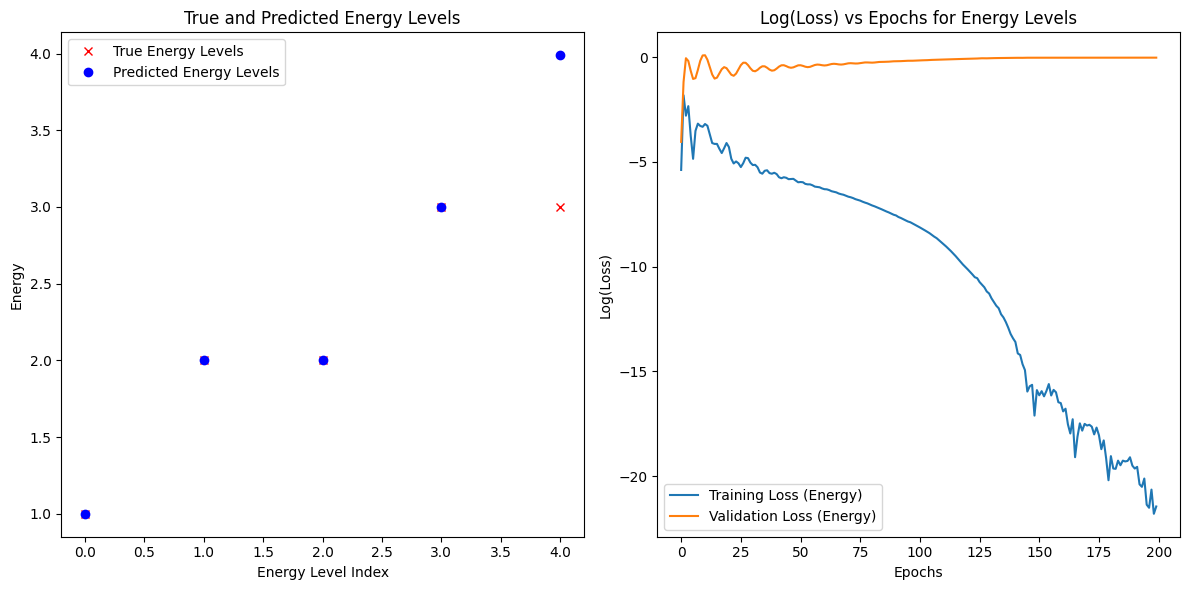

In [20]:
predicted_energy_levels = exp_2.predict(energy_indices)
exp_2.plot_results(true_energy_levels, predicted_energy_levels, levels)

In [21]:
exp_2.accuracy_metric(true_energy_levels, predicted_energy_levels)
reports.append(exp_2.report())

Mean Squared Error (Energy Levels): 0.1955575560025295


### Experiment 3 - Sample Size of 100000


**NOTE THAT THE KERNEL KEEPS CRASHING AT THIS POINT**

In [22]:
model_energy_2 = Sequential([
    Input(shape=(1,)),
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dense(256, activation='tanh'),
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dense(256, activation='tanh'),
    Dense(1, activation='linear')
])

In [23]:
exp_3 = Experiment(model=model_energy_2, optimizer=Adam(learning_rate=0.001), loss='mse', model_version='v2')
energy_indices, true_energy_levels, levels = exp_3.generate_data(n_samples=100000)
exp_3.fit(energy_indices, true_energy_levels, epochs=200, batch_size=2500, validation_split=0.2)

Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 4.3839 - val_loss: 5.1920
Epoch 2/200
1/1 [==============================] - 0s 32ms/step - loss: 3.1685 - val_loss: 1.2041
Epoch 3/200
1/1 [==============================] - 0s 34ms/step - loss: 1.4985 - val_loss: 1.0240
Epoch 4/200
1/1 [==============================] - 0s 29ms/step - loss: 0.2982 - val_loss: 10.6991
Epoch 5/200
1/1 [==============================] - 0s 30ms/step - loss: 2.0525 - val_loss: 5.4645
Epoch 6/200
1/1 [==============================] - 0s 30ms/step - loss: 0.8847 - val_loss: 1.0617
Epoch 7/200
1/1 [==============================] - 0s 29ms/step - loss: 0.2392 - val_loss: 0.0058
Epoch 8/200
1/1 [==============================] - 0s 30ms/step - loss: 0.4058 - val_loss: 0.1706
Epoch 9/200
1/1 [==============================] - 0s 30ms/step - loss: 0.6635 - val_loss: 0.3096
Epoch 10/200
1/1 [==============================] - 0s 31ms/step - loss: 0.7353 - val_loss: 0.2023
Epoch 11/200
1/1 [==

1/1 [==============================] - 0s 112ms/step


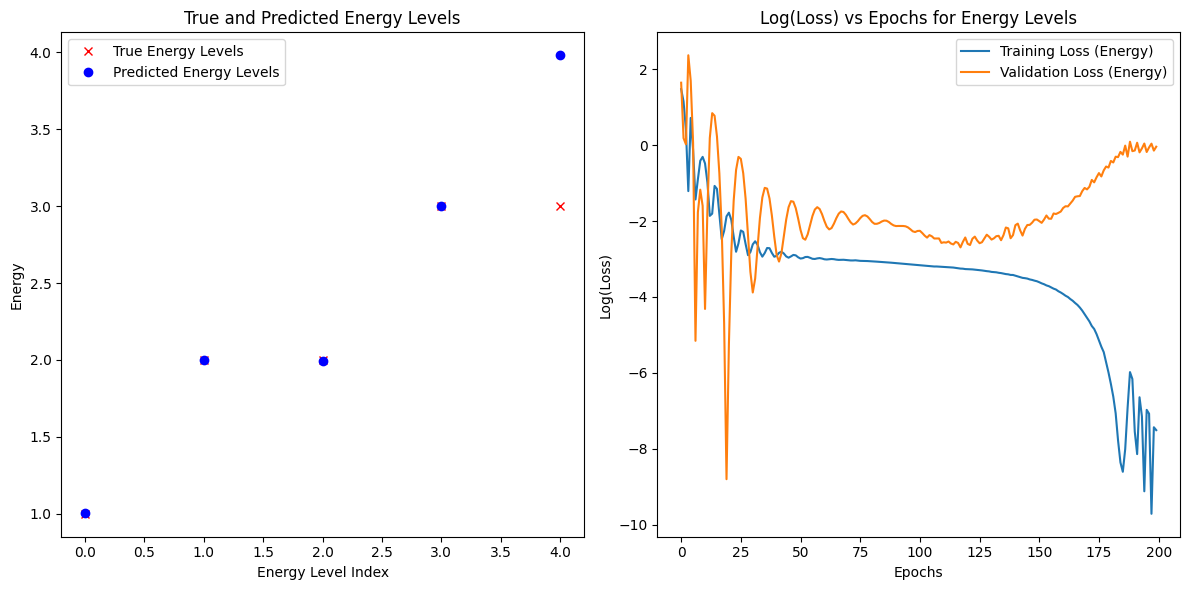

In [24]:
predicted_energy_levels = exp_3.predict(energy_indices)
exp_3.plot_results(true_energy_levels, predicted_energy_levels, levels)

In [25]:
exp_3.accuracy_metric(true_energy_levels, predicted_energy_levels)
reports.append(exp_3.report())

Mean Squared Error (Energy Levels): 0.19224343867735455


## Let's Try Support Vector Machine

In [26]:
class SVRExperiment:
  def __init__(self, **kwargs):
    self.model = kwargs.get('model')
    self.model_type = 'Support Vector Regressor'
    self.model_version = kwargs.get('model_version')

  def set_model(self, model_params):
    self.model = SVR(**model_params)

  def set_hyperparameters(self, **kwargs):
    self.__dict__.update(kwargs)

  def absorb_data(self, X, y, *, test_size=0.2, seed=42):
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=test_size, random_state=seed)


    print(f"The dataset has been divided as follows: training: 80%, test: 20%")
    return self.X_test, self.y_test

  @timer
  def fit(self):
    self.model.fit(self.X_train, self.y_train)

  def predict(self, X):
    predicted_energy_levels = self.model.predict(X)
    return predicted_energy_levels

  def evaluate(self):
    predicted_energy_levels = self.predict(self.X_test)
    self.mse_energy_levels = mean_squared_error(predicted_energy_levels, self.y_test)

    print(f'Mean Squared Error (Energy Levels): {self.mse_energy_levels}')
    return predicted_energy_levels, self.mse_energy_levels


  def plot_results(self, true_energy_levels, predicted_energy_levels_svr, levels):
    plt.figure()
    plt.plot(np.arange(len(levels)), true_energy_levels, 'rx', label='True Energy Levels')
    plt.plot(np.arange(len(levels)), predicted_energy_levels_svr, 'bo', label='Predicted Energy Levels (SVR)')
    plt.xlabel('Energy Level Index')
    plt.ylabel('Energy')
    plt.title('True and Predicted Energy Levels (SVR)')
    plt.legend()
    plt.show()


  def report(self):
    return ModelReport(
        model_type=self.model_type,
        model_version=self.model_version,
        fit_duration=self._method_durations['fit'],
        mean_squared_error=self.mse_energy_levels
    )


  def run(self, n_samples=100000):
    energy_indices, true_energy_levels, levels = Experiment.generate_data(n_samples=n_samples)
    self.absorb_data(energy_indices, true_energy_levels)
    self.fit()
    _, mse_energy_levels = self.evaluate()

    return mse_energy_levels


  def test_model(self, n_samples=100000):
    energy_indices, true_energy_levels, levels = Experiment.generate_data(n_samples=n_samples)
    predicted_energy_levels_svr= self.predict(energy_indices)

    self.plot_results(true_energy_levels, predicted_energy_levels_svr, levels)

In [27]:
# @title Generate data and instantiate model

# Generate data
energy_indices, true_energy_levels, levels = Experiment.generate_data(n_samples=1000)

# Create SVR model
svr_model = SVR()

In [28]:
# @title Setup grid search
# Define parameter grid for grid search
param_grid = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'gamma': [1e-3, 1e-4, 'scale', 'auto'],
    'epsilon': [0.01, 0.05, 0.1, 0.5]
}

scoring = make_scorer(mean_squared_error, greater_is_better=False)

# Create GridSearchCV object
grid_search = GridSearchCV(svr_model, param_grid, cv=5, scoring=scoring)

In [29]:
# @title Search hyperparameter space for best option
# Fit the model using grid search
grid_search.fit(energy_indices, true_energy_levels)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

In [30]:
# Print the best parameters and best score
print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")

Best Parameters: {'C': 100, 'epsilon': 0.1, 'gamma': 0.001, 'kernel': 'linear'}
Best Score: -0.18199999999888294


In [31]:
# @title Try best params in model
svr_model = SVR(**best_params)
svr_experiment_1 = SVRExperiment(model=svr_model, model_version='linear_kernel')
svr_experiment_1.run(n_samples=10000)

The dataset has been divided as follows: training: 80%, test: 20%


Method fit took 0.0015 seconds to run.


Mean Squared Error (Energy Levels): 0.15999999999999992


0.15999999999999992

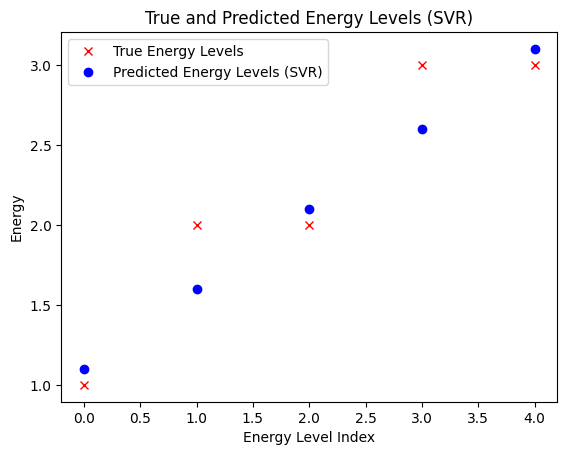

In [32]:
svr_experiment_1.test_model(n_samples=100)
reports.append(svr_experiment_1.report())

In [33]:
# @title Try a non-linear kernel
svr_model_2 = SVR(
    kernel='rbf',
    C=10,
    gamma=2,
    epsilon=0.01
)

svr_experiment_2 = SVRExperiment(model=svr_model_2, model_version='rbf_kernel')
svr_experiment_2.run(n_samples=10)

The dataset has been divided as follows: training: 80%, test: 20%


Method fit took 0.0014 seconds to run.


Mean Squared Error (Energy Levels): 0.00012213667096547132


0.00012213667096547132

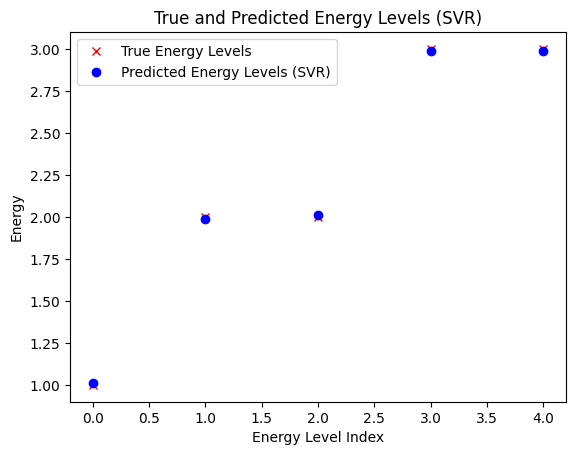

In [34]:
svr_experiment_2.test_model(n_samples=1000)
reports.append(svr_experiment_2.report())

### Another Non-Linear Kernel

In [35]:
svr_model_3 = SVR(
    kernel='sigmoid',
    C=10,
    gamma='scale',
    epsilon=0.1
)

svr_experiment_3 = SVRExperiment(model=svr_model_3, model_version='sigmoid_kernel')
svr_experiment_3.run(n_samples=100000)

The dataset has been divided as follows: training: 80%, test: 20%


Method fit took 0.0013 seconds to run.


Mean Squared Error (Energy Levels): 8.27018148246173


8.27018148246173

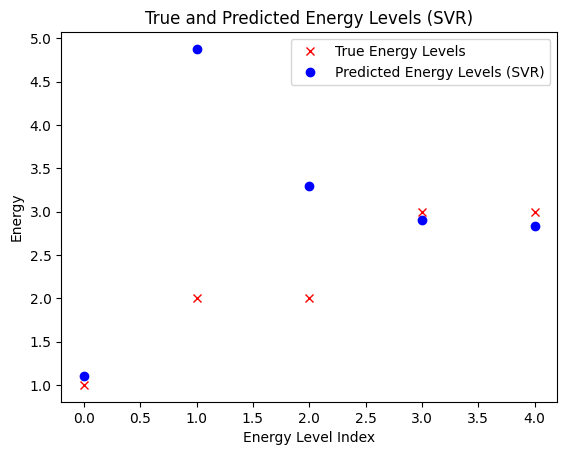

In [36]:
svr_experiment_3.test_model(n_samples=100)
reports.append(svr_experiment_3.report())

In [37]:
svr_model_4 = SVR(
    kernel='poly',
    C=10,
    gamma=2,
    epsilon=0.001
)

svr_experiment_4 = SVRExperiment(model=svr_model_4, model_version='poly_kernel')
svr_experiment_4.run(n_samples=100000)

The dataset has been divided as follows: training: 80%, test: 20%


Method fit took 0.0094 seconds to run.


Mean Squared Error (Energy Levels): 0.01593906249834206


0.01593906249834206

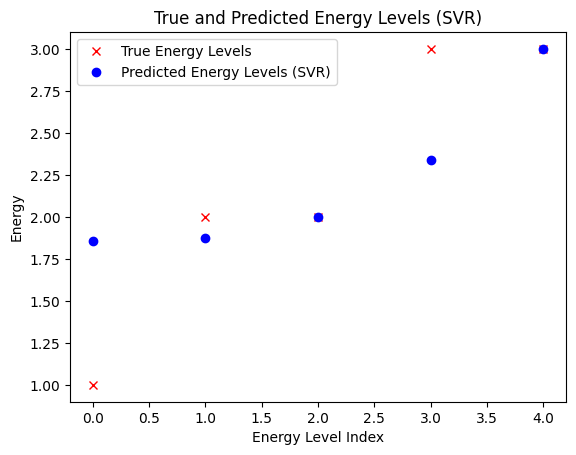

In [38]:
svr_experiment_4.test_model(n_samples=100)
reports.append(svr_experiment_4.report())

# Analysis

In [39]:
reports_df = pd.DataFrame(reports)
reports_df['model'] = reports_df.apply(lambda row: f"{row['model_type']} - {row['model_version']}", axis=1)

In [40]:
reports_df

,model_type,model_version,fit_duration,mean_squared_error,model
0,Multi_Layer_Perceptron,v1,42.332622,0.116255,Multi_Layer_Perceptron - v1
1,Multi_Layer_Perceptron,v1a,8.606242,0.113727,Multi_Layer_Perceptron - v1a
2,Multi_Layer_Perceptron,v1b,10.035026,0.117956,Multi_Layer_Perceptron - v1b
3,Multi_Layer_Perceptron,v2,9.591151,0.195558,Multi_Layer_Perceptron - v2
4,Multi_Layer_Perceptron,v2,10.881402,0.192243,Multi_Layer_Perceptron - v2
5,Support Vector Regressor,linear_kernel,0.001462,0.160000,Support Vector Regressor - linear_kernel
6,Support Vector Regressor,rbf_kernel,0.001350,0.000122,Support Vector Regressor - rbf_kernel
7,Support Vector Regressor,sigmoid_kernel,0.001311,8.270181,Support Vector Regressor - sigmoid_kernel
8,Support Vector Regressor,poly_kernel,0.009440,0.015939,Support Vector Regressor - poly_kernel


## Inspect best results by group

In [41]:
groups = reports_df.groupby('model_type').agg({'fit_duration': 'min', 'mean_squared_error': 'min'})
groups

,fit_duration,mean_squared_error
model_type,,
Multi_Layer_Perceptron,8.606242,0.113727
Support Vector Regressor,0.001311,0.000122


## Compare all model performances

In [42]:
categories = reports_df['model'].unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(categories)))
color_map = dict(zip(categories, colors))

reports_df['color'] = reports_df['model'].map(color_map)

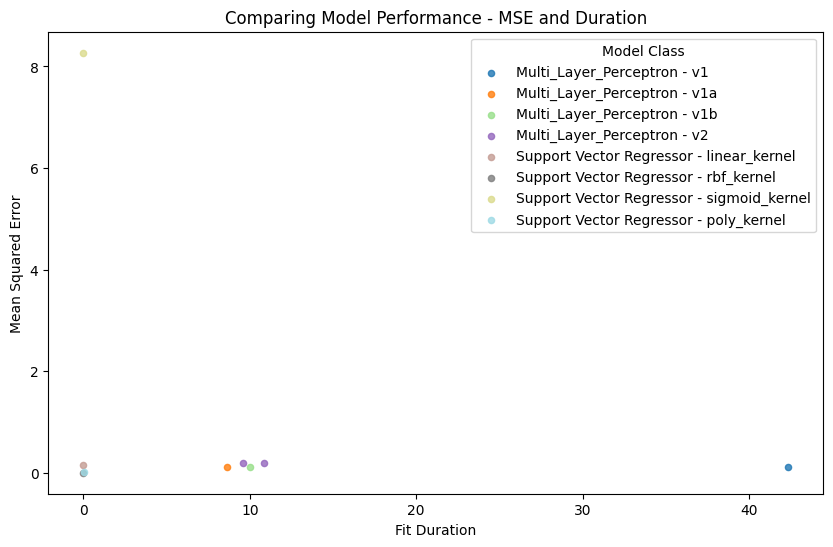

In [43]:
plt.figure(figsize=(10, 6))
for category in categories:
    subset = reports_df[reports_df['model'] == category]
    plt.scatter(subset['fit_duration'], subset['mean_squared_error'],
                s=20, alpha=0.8, color=color_map[category], label=category)

# Add labels and title
plt.xlabel('Fit Duration')
plt.ylabel('Mean Squared Error')
plt.title('Comparing Model Performance - MSE and Duration')

# Add legend
plt.legend(title='Model Class')
plt.show()